In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from IPython.display import display, HTML
from collections import defaultdict
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from datasets.Waymo import WaymoDataset, waymo_collate_fn
from model import OccupancyFlowNetwork
from visualize import render_observed_scene_state, render_flow_at_spacetime, render_flow_field, render_occupancy_and_flow_unoccluded

In [2]:
NUM_SCENES = 1
MAX_SCENES_TO_RENDER = 1

tfrecord_path = '../../data1/waymo_dataset/v1.1/waymo_open_dataset_motion_v_1_1_0/uncompressed/tf_example/validation'
idx_path = '../../data1/waymo_dataset/v1.1/idx/validation'
dataset = WaymoDataset(tfrecord_path, idx_path)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=waymo_collate_fn)

scenes = []
for _ in range(NUM_SCENES):
    scenes.append(next(iter(dataloader)))

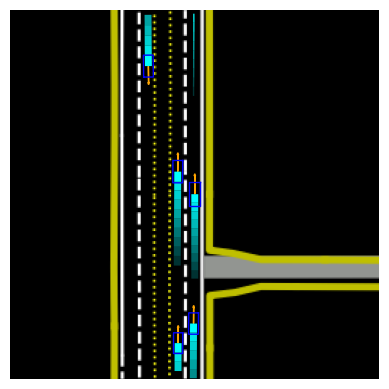

In [3]:
count = 0
for road_map, agent_trajectories, _, _, _, _, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break
    
    render_observed_scene_state(road_map[0], agent_trajectories[0])

In [4]:
count = 0
for road_map, _, _, flow_field_positions, flow_field_times, flow_field_velocities, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break
    
    anim = render_flow_at_spacetime(road_map[0], flow_field_times[0], flow_field_positions[0], flow_field_velocities[0])
    display(HTML(anim.to_jshtml()))

torch.Size([3528, 1])


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

In [ ]:
def occupancy_alignment(flow_field, scene_context,
                        agent_ids, positions, times):
    occupancy_loss = 0
    count = 0

    agent_groups = defaultdict(list)
    [agent_groups[round(val.item(), 1)].append(idx) for idx, val in enumerate(agent_ids)]

    for indices in agent_groups.values():
        agent_poistions = positions[indices]
        agent_times = times[indices]
        
        time_groups = defaultdict(list)
        [time_groups[round(val.item(), 1)].append(idx) for idx, val in enumerate(agent_times)]

        occupancy = []
        integration_times = []

        for time, indices in time_groups.items():
            integration_times.append(time)
            occupancy.append(agent_poistions[indices])

        initial_value = occupancy[0].unsqueeze(0)
        integration_times = torch.FloatTensor(integration_times).to(times.device)
        estimated_occupancy = flow_field.warp_occupancy(initial_value, integration_times, scene_context)

        for i in range(len(occupancy)):
            occupancy_loss += torch.mean(torch.abs(estimated_occupancy[i].squeeze(0) - occupancy[i]))
            count += 1
            
    return occupancy_loss / count

In [ ]:
flow_field = OccupancyFlowNetwork(road_map_image_size=256, road_map_window_size=8, 
                                  trajectory_feature_dim=10, 
                                  embedding_dim=256, 
                                  flow_field_hidden_dim=256, flow_field_fourier_features=128).to(device)
flow_field.train()


optim = torch.optim.Adam(flow_field.parameters(), lr=1e-4, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

EPOCHS = 1000
for epoch in range(EPOCHS):
    epoch_loss = 0
    for road_map, agent_trajectories, flow_field_agent_ids, flow_field_positions, flow_field_times, flow_field_velocities, _, _ in scenes:
        road_map = road_map.to(device)
        agent_trajectories = agent_trajectories.to(device)
        p = flow_field_positions.to(device)
        t = flow_field_times.to(device)
        v = flow_field_velocities.to(device)
    
        scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
        flow = flow_field.flow_field(t, p, scene_context)

        flow_loss = F.mse_loss(flow, v)
        loss = flow_loss

        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow_field.parameters(), max_norm=1.0)
        optim.step()

        epoch_loss += loss

    scheduler.step()

    epoch_loss /= NUM_SCENES
    
    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f'epoch {epoch+1} loss: {epoch_loss.item()}')

In [ ]:
optim = torch.optim.Adam(flow_field.parameters(), lr=1e-8, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

EPOCHS = 1000
for epoch in range(EPOCHS):
    epoch_flow_loss = 0
    epoch_occupancy_loss = 0
    epoch_loss = 0
    for road_map, agent_trajectories, flow_field_agent_ids, flow_field_positions, flow_field_times, flow_field_velocities, _, _ in scenes:
        road_map = road_map.to(device)
        agent_trajectories = agent_trajectories.to(device)
        p = flow_field_positions.to(device)
        t = flow_field_times.to(device)
        v = flow_field_velocities.to(device)
    
        scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
        flow = flow_field.flow_field(t, p, scene_context)

        flow_loss = F.mse_loss(flow, v)
        occupancy_loss = occupancy_alignment(flow_field, scene_context,
                                             flow_field_agent_ids[0], p[0], t[0])
        loss = flow_loss + occupancy_loss

        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow_field.parameters(), max_norm=1.0)
        optim.step()

        epoch_flow_loss += flow_loss
        epoch_occupancy_loss += occupancy_loss
        epoch_loss += loss

    scheduler.step()

    epoch_flow_loss /= NUM_SCENES
    epoch_occupancy_loss /= NUM_SCENES
    epoch_loss /= NUM_SCENES
    
    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f'epoch {epoch+1} flow_loss: {flow_loss.item()}')
        print(f'epoch {epoch+1} occupancy_loss: {occupancy_loss.item()}')
        print(f'epoch {epoch+1} loss: {epoch_loss.item()}')

In [ ]:
count = 0
for road_map, agent_trajectories, _, flow_field_positions, flow_field_times, _, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break

    road_map = road_map.to(device)
    agent_trajectories = agent_trajectories.to(device)
    p = flow_field_positions.to(device)
    t = flow_field_times.to(device)
    flow = flow_field(t, p, road_map, agent_trajectories)

    anim = render_flow_at_spacetime(road_map[0].cpu(), flow_field_times[0].cpu(), flow_field_positions[0].cpu(), flow[0].detach().cpu())
    display(HTML(anim.to_jshtml()))

In [ ]:
count = 0
for road_map, agent_trajectories, _, _, _, _, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break

    road_map = road_map.to(device)
    agent_trajectories = agent_trajectories.to(device)
    
    scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
    anim = render_flow_field(flow_field, road_map, road_map[0].shape[0], 10, 91, 10, scene_context)
    display(HTML(anim.to_jshtml()))

In [ ]:
count = 0
for road_map, agent_trajectories, _, positions, times, _, _, _ in scenes:
    count += 1
    if count > MAX_SCENES_TO_RENDER:
        break

    road_map = road_map.to(device)
    agent_trajectories = agent_trajectories.to(device)
    positions = positions.to(device)
    times = times.to(device)
    
    scene_context = flow_field.scene_encoder(road_map, agent_trajectories)
    anim = render_occupancy_and_flow_unoccluded(flow_field, road_map, times, positions, 11, scene_context)
    display(HTML(anim.to_jshtml()))